#### Video demonstration link: https://csulb-my.sharepoint.com/:v:/g/personal/abhinay_kacham_student_csulb_edu/EdLFuG0dS_BNsyApETmFv5IBIMAYf516jV30ga_ZCEOfsA?e=JeJuPc



In [128]:
import numpy as np
import pandas as pd
import csv

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

from mpl_toolkits import mplot3d

import seaborn as sns
import matplotlib.pyplot as plt

### Data Analysis and missing data analysis. 
- Is there missing data?
- Can we afford to remove data points?
- Do we use imputation (and introduce additional uncertainty)? 

#### Solving above queries in the following way (Imputation)

- Replacing error(?) with NaN in all columns and removing entire record if there is no class for the entry
- If I have huge data I am deleting the record.
- if I have few records I am updating the error cell with mean of that column (Imputation).

In [129]:
def _data_wrangling(df):
    df.drop(df[df.C == '?'].index, inplace=True)
    df.replace(to_replace={'C':{2:'benign'}},inplace=True)
    df.replace(to_replace={'C':{4:'malignant'}},inplace=True)
    y = df['C']
    df.drop(columns=['C','id'],inplace=True)
    df.replace('?', np.NaN,inplace=True)
    if df.shape[0] > 100000:
        df.dropna(inplace=True)
    else:
        df = df.apply(lambda x: x.fillna(x.median()),axis=0)
    return df,y

#### Scaling the data

In [130]:
def scale_data(X):
    X_scaled = X.copy()
    col_names = X.columns    
    features = X_scaled[col_names]
    scaler = StandardScaler()
    X_scaled[col_names] = scaler.fit_transform(features.values)
    return X_scaled

#### Importing the dataset

In [131]:
df = pd.read_csv('breast-cancer-wisconsin.csv')
X,y =_data_wrangling(df)
scaled_X = scale_data(X)

#### Feature distribution plot for all features

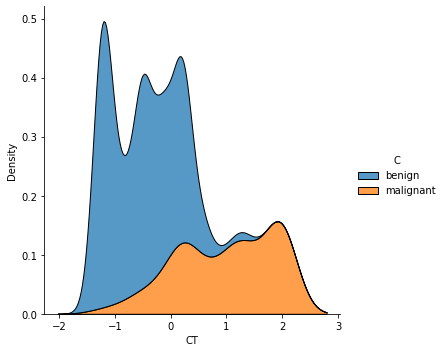

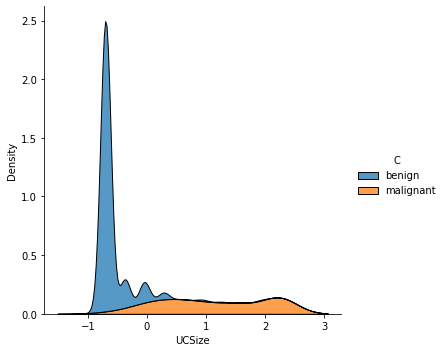

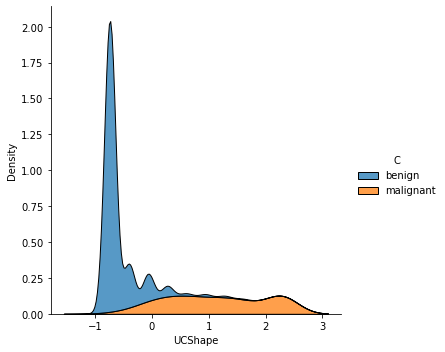

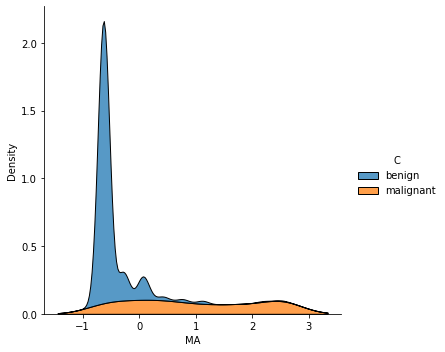

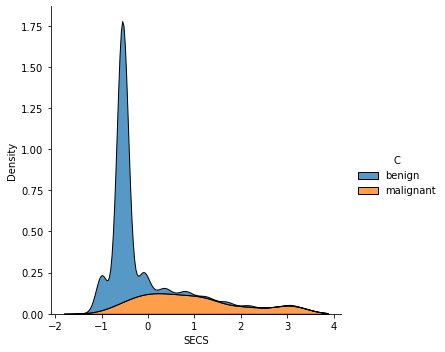

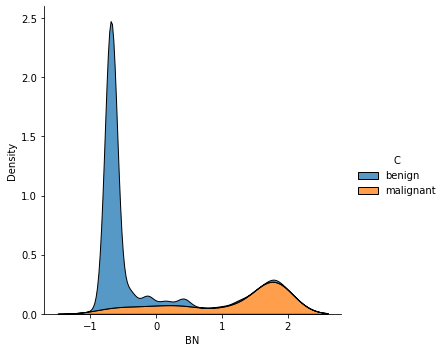

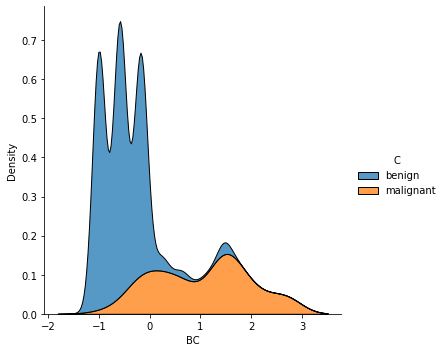

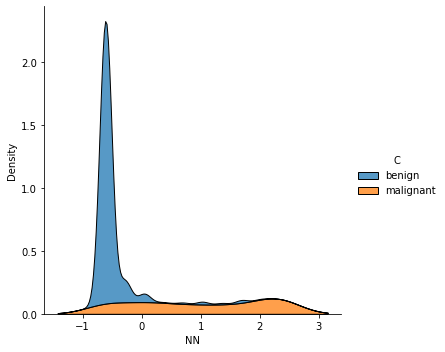

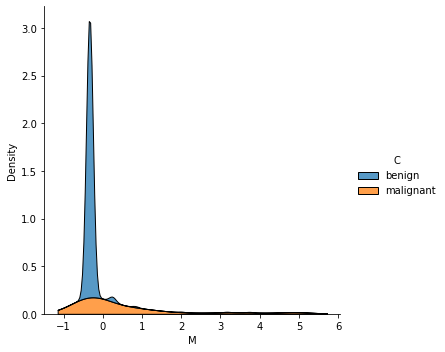

In [132]:
both=pd.concat((scaled_X,y),axis=1)
for col in scaled_X.columns:
    if col not in ('C'):
        sns.displot(both, x=col, hue='C', kind='kde', multiple='stack')

#### Handling outliers

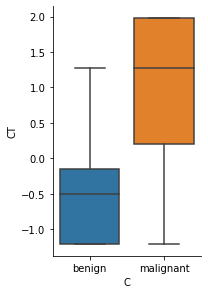

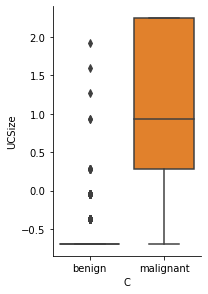

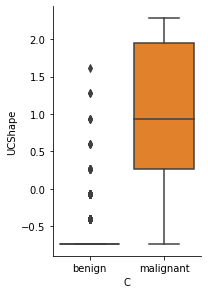

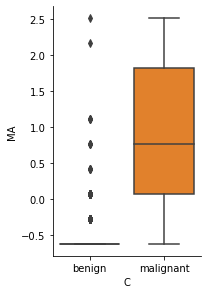

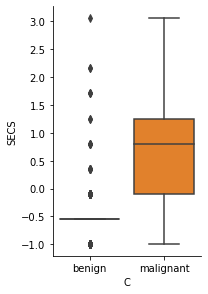

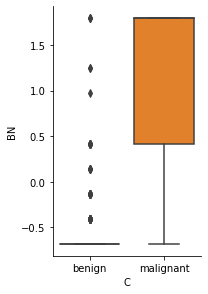

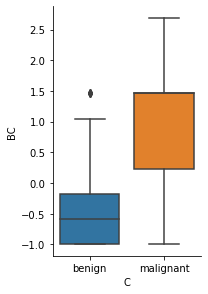

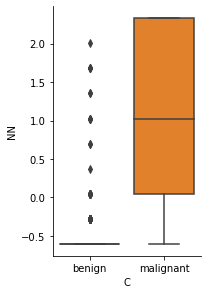

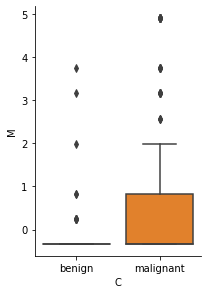

In [133]:
for col in both.columns:
    if col != 'C':
        sns.catplot(x='C',y=col, data=both, kind="box",height=4, aspect=.7)

##### BENIGN class is not spread rather has high concentration at the small range, that caused the huge peek in density plot and lead to outliers for almost all other recorded data in some of the features in BENIGN.

##### MALIGNANT class has well distribited data, that is the reason we can see density plot is relatively flat compared to BENIGN class. Also, the evenly distribution of data lead to few outliers.

#### Heatmap plot for coorelation of all features

<AxesSubplot:>

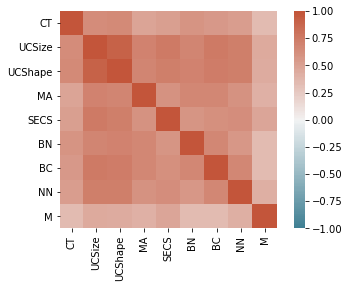

In [134]:
correlation = scaled_X.corr()
sns.heatmap(
    correlation, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(220, 20, n=200),
    square=True
)


##### From the heatmap we can deduce that there aren't columns with negatively correlation, and most of them are with very minimal correlation.  UCSize and UCShape are highly correlated among all followed by UCSIze and CT, UCShape and CT.

#### Principal Component Analysis (PCA)

##### Creating multiple datasets from original dataset using PCA

In [135]:
#This object consists of different datasets that we are going to compare at the end of the Jupyter notebook
datasets = []

# Adding original dataset to list of datasets
datasets.append(tuple((scaled_X,'Original dataset')))

# creating dataset with 2 components from original dataset
pca_2 = PCA(n_components=2,random_state=2)
pca_2.fit(scaled_X)
scaled_X_pca_2 = pca_2.transform(scaled_X)
datasets.append(tuple((scaled_X_pca_2,'scaled dataset with 2 principal components')))

# creating dataset with 6 components from original dataset
pca_6 = PCA(n_components=6,random_state=2)
pca_6.fit(scaled_X)
datasets.append(tuple((pca_6.transform(scaled_X),'scaled dataset with 6 principal components')))

##### plotting pc1 vs pc2

In [136]:
#sns.scatterplot(x=scaled_X_pca_2[:,0],y=scaled_X_pca_2[:,1],s=30,hue=y,palette=['green','blue'])

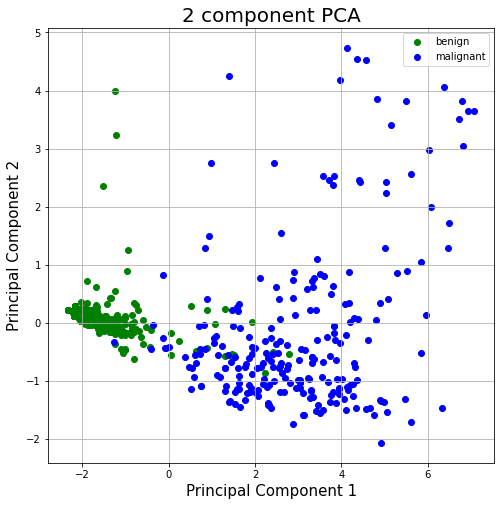

In [137]:
principalDf = pd.DataFrame(data = scaled_X_pca_2
             , columns = ['principal component 1', 'principal component 2'])

finalDf = pd.concat([principalDf, y], axis = 1)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['benign','malignant']
colors = ['g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['C'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color)
ax.legend(targets)
ax.grid()
plt.show()

##### Iterating through each dataset created in previous step, calculating accuracy of classification for KNN and Random forest classifier

In [138]:
knn = KNeighborsClassifier()
clf = RandomForestClassifier(criterion='gini', n_estimators = 120, random_state=0)

for t in datasets:
    X = t[0]
    desc = t[1]
    print('Stats of '+desc)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy_score_of_knn = accuracy_score(y_test, y_pred)
    print("Accuracy score of KNN is: "+str(round(accuracy_score_of_knn*100,3))+'%')
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy_score_of_clf = accuracy_score(y_test,y_pred)
    print("Accuracy score of RFC is: "+str(round(accuracy_score_of_clf*100,3))+'%')
    print()
    if accuracy_score_of_knn > accuracy_score_of_clf:
        print('Accuracy of KNN is better compared to Random forest classifier')
    elif accuracy_score_of_knn < accuracy_score_of_clf:    
        print('Accuracy of Random forest classifier is better compared to KNN')
    else:
        print('Accuracy of KNN is equal to Random forest classifier')
    print()

Stats of Original dataset
Accuracy score of KNN is: 97.143%
Accuracy score of RFC is: 97.143%

Accuracy of KNN is equal to Random forest classifier

Stats of scaled dataset with 2 principal components
Accuracy score of KNN is: 96.429%
Accuracy score of RFC is: 96.429%

Accuracy of KNN is equal to Random forest classifier

Stats of scaled dataset with 6 principal components
Accuracy score of KNN is: 97.143%
Accuracy score of RFC is: 97.857%

Accuracy of Random forest classifier is better compared to KNN



#### After running the train_test_split() for several times my observation is, there is no huge difference between the accuracy of two classifiers. There is atmost 2% difference and the lead is oscilating between two classifiers based on train_test_split() method that splits the dataset to train and test data.

Citations:
- https://www.geeksforgeeks.org/how-to-get-column-names-in-pandas-dataframe/
- https://thispointer.com/pandas-replace-nan-with-mean-or-average-in-dataframe-using-fillna/
- https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.count.html
- https://stackoverflow.com/questions/29247712/how-to-replace-a-value-in-pandas-with-nan
- http://joshlawman.com/dealing-with-missing-data-imputation-with-pandas/
- https://pydatascience.org/2019/07/26/impute-nan-values-with-mean-of-column-pandas-python/
- https://stackoverflow.com/questions/56903019/i-am-calling-the-mean-function-but-i-am-getting-typeerror-can-only-concatenate
- https://seaborn.pydata.org/tutorial/distributions.html
- https://seaborn.pydata.org/generated/seaborn.boxplot.html
- http://www.datasciencesmachinelearning.com/2018/11/handling-outliers-in-python.html
- https://matplotlib.org/stable/gallery/mplot3d/scatter3d.html
- https://towardsdatascience.com/principal-component-analysis-pca-with-scikit-learn-1e84a0c731b0
- and CECS 550 Python videos